In [1]:
%load_ext autoreload
%autoreload 2
    
import os, sys
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from emimage.models import EMImage
from mims.models import MIMSImage, MIMSImageSet
from PIL import Image
from scipy.ndimage import rotate
import pprint
import sims

True 161 [75335 47758]
EM size is  (42628, 33469)
time0: 4.52154803276062
mims_image_sets/a5400e99-227e-4e37-9ca4-359e550d1a8f/mims_images/1035_position_2.im time1 4.522541046142578
time5: 5.4520580768585205 [20640.625, 7203.125] 0.5217893719673157


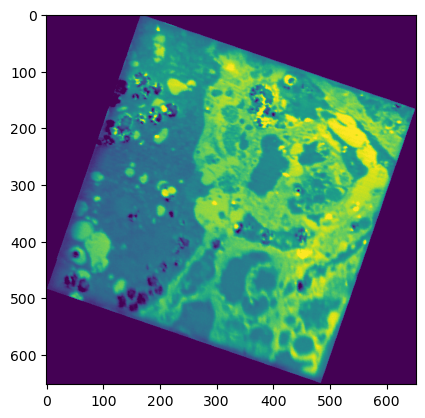

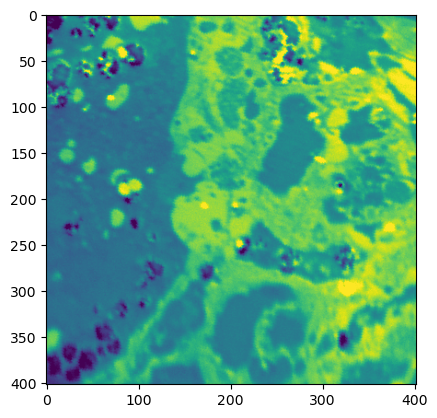

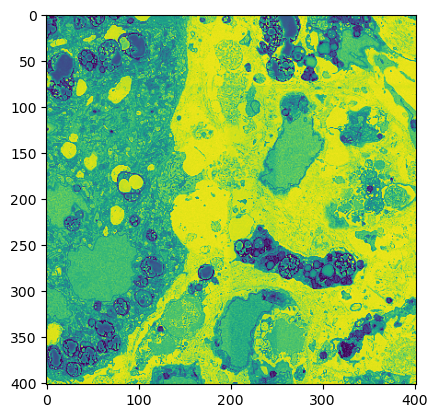

mims_image_sets/a5400e99-227e-4e37-9ca4-359e550d1a8f/mims_images/1035_position_3.im time1 5.747997283935547
time5: 6.6764771938323975 [11859.375, 19000.0] 0.4175558090209961


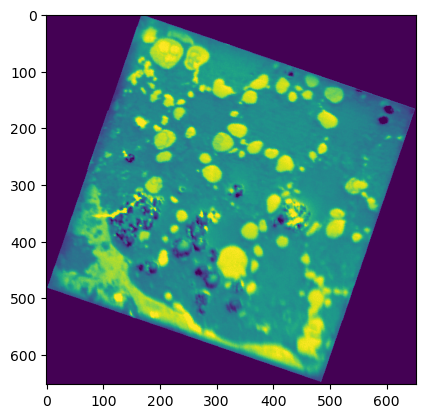

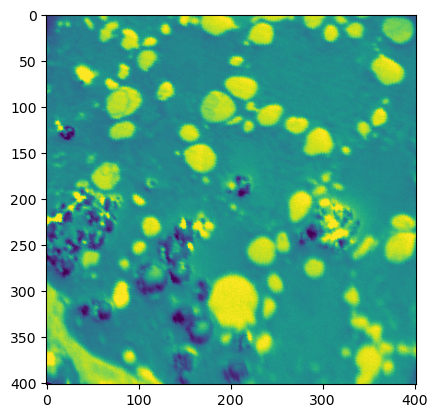

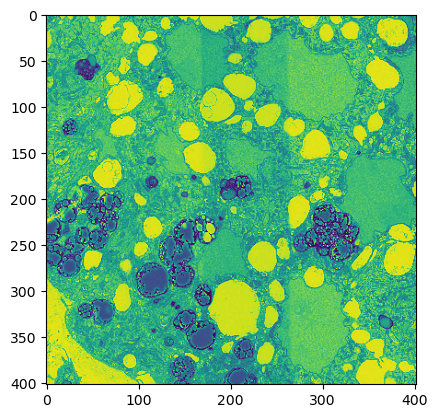

In [2]:
from mims.services.concat_utils import get_concatenated_image, get_autocontrast_image_path
import cv2
import time

def largest_inner_square(side_length, angle):
    """Calculate the largest possible inner square side length for a given rotation angle."""
    # Convert angle to radians
    return side_length / (abs(math.cos(math.radians(angle))) + abs(math.sin(math.radians(angle))))

def calculate_individual_mims_translations(mims_imageviewset):
    start = time.time()
    # Print seconds elapsed
    mims_images = mims_imageviewset.mims_images.all()
    # Get transformation parameters
    flip = mims_imageviewset.flip
    rotation_degrees = mims_imageviewset.rotation_degrees
    composite_translation = np.array(
        [mims_imageviewset.em_coordinates_x, mims_imageviewset.em_coordinates_y]
    )
    print(flip, rotation_degrees, composite_translation)
    scale = mims_imageviewset.em_scale
    isotope = "SE"#mims_images[0].isotopes.all()[0]
    composite_image = Image.fromarray(get_concatenated_image(imageviewset, isotope))
    if flip:
        composite_image = composite_image.transpose(Image.FLIP_LEFT_RIGHT)
    composite_image = composite_image.rotate(rotation_degrees, expand=True)
    composite_image = np.array(composite_image)
    scale = mims_imageviewset.mims_images.first().pixel_size_nm / (mims_imageviewset.em_image.pixel_size_nm or 5)
    # Load the EM image as a numpy array
    em_image = Image.open(mims_imageviewset.em_image.file.path)
    em_image_array = np.array(em_image)
    print("EM size is ", em_image_array.shape)
    scaled_em = cv2.resize(em_image_array, (int(em_image_array.shape[1] / scale), int(em_image_array.shape[0] / scale)))
    print("time0:", time.time()-start)
    # Calculate and store translations for each MIMS image
    for mims_image in mims_images[1:3]:
        print(mims_image.file.name, "time1", time.time()-start)
        # Load the MIMS image for the isotope and load as PIL image
        img_orig = get_autocontrast_image_path(mims_image, isotope)
        img_orig = Image.open(img_orig)
        img = img_orig.copy()
        # Apply the flip and rotation if necessary to it
        img = img.rotate(-rotation_degrees, expand=True)
        if flip:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        img_array = np.array(img)
        
        # Calculate the center of the image
        center_x, center_y = img_array.shape[1] // 2, img_array.shape[0] // 2

        # Calculate the cropping box
        largest_inner_square_side = int(largest_inner_square(img_orig.width, rotation_degrees))
        start_x = center_x - largest_inner_square_side // 2
        start_y = center_y - largest_inner_square_side // 2
        end_x = center_x + largest_inner_square_side // 2
        end_y = center_y + largest_inner_square_side // 2

        # Crop the image to the largest inner square
        cropped_img_array = img_array[start_y:end_y, start_x:end_x]

        # Then find the image in the composite image
        result = cv2.matchTemplate(composite_image, img_array, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        # Now from this approximation, find a closer match in the actual EM image
        # skip for now
        
        # Crop the EM image around the location of the MIMS image
        #crop_size = int(img_array.shape[0]*scale * 1.2)
        #crop = em_image_array[
        #    max(mims_y - crop_size, 0):mims_y + crop_size*2, max(mims_x - crop_size,0):mims_x + crop_size*2
        #]
        # Scale down the crop to the size of the MIMS image using the scale parameter
        #crop = cv2.resize(crop, (int(crop.shape[1] / scale), int(crop.shape[0] / scale)))
        # Now find the MIMS image in the crop
        # These 2 calls take ~0.3 seconds
        result = cv2.matchTemplate(scaled_em, cropped_img_array, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        print("time5:", time.time()-start, [max_loc[1]*scale, max_loc[0]*scale], max_val)
        
        # Calculate the translation in the EM image
        plt.imshow(img_array)
        plt.show()
        plt.imshow(cropped_img_array)
        plt.show()
        adjust=img_array.shape[0]//10
        plt.imshow(scaled_em[max_loc[1]:max_loc[1]+cropped_img_array.shape[0], max_loc[0]:max_loc[0]+cropped_img_array.shape[1]])
        plt.show()

    return

imageviewset = MIMSImageSet.objects.get(id="a5400e99-227e-4e37-9ca4-359e550d1a8f")
calculate_individual_mims_translations(imageviewset)

In [8]:
import numpy as np
from skimage.transform import estimate_transform
from skimage import transform
import sims


def calculate_transformation_error(tform, src_points, dst_points):
    # Apply the transformation to the source points
    transformed_points = tform(src_points)
    # Calculate the error as the sum of squared differences
    error = np.sum((transformed_points - dst_points) ** 2)
    return error


def orient_viewset(mims_imageviewset, points):
    # This function takes a MIMSImageViewSet object and a list of points as input.
    # The points are in the format of
    # {
    #   "em": [{x: x1, y: y1}, {x: x2, y: y2}, {x: x3, y: y3}],
    #   "mims": [{x: x1, y: y1}, {x: x2, y: y2}, {x: x3, y: y3}]
    # }
    # It then calculates the rotation and flip needed to align the MIMS image to the EM image,
    # as well as the scale needed to match the pixel size of the MIMS image to the EM image and
    # the translation needed to align the MIMS image to the EM image.
    em_points = np.array([[point["y"], point["x"]] for point in points["em"]])
    mims_points = np.array([[point["y"], point["x"]] for point in points["mims"]])
    tform_no_flip = estimate_transform("similarity", mims_points, em_points)
    error_no_flip = calculate_transformation_error(
        tform_no_flip, mims_points, em_points
    )

    isotope = "SE"
    composite_image = Image.fromarray(get_concatenated_image(imageviewset, isotope))
    composite_dims = composite_image.size

    # Scenario 2: Flip the MIMS points horizontally (flip x-coordinates)
    mims_points_flipped = mims_points.copy()
    # Flip x-coordinates around the center of the composite image
    mims_points_flipped[:, 1] = composite_dims[1] - mims_points_flipped[:, 1]  

    tform_with_flip = estimate_transform("similarity", mims_points_flipped, em_points)
    error_with_flip = calculate_transformation_error(
        tform_with_flip, mims_points_flipped, em_points
    )

    if error_with_flip < error_no_flip:
        selected_tform = tform_with_flip
        flip = True
    else:
        selected_tform = tform_no_flip
        flip = False

    # Extract transformation parameters
    scale = np.sqrt(selected_tform.params[0, 0] ** 2 + selected_tform.params[1, 0] ** 2)
    rotation_radians = np.arctan2(
        selected_tform.params[1, 0], selected_tform.params[0, 0]
    )
    rotation_degrees = np.degrees(rotation_radians)
    translation = selected_tform.params[:2, 2]
    # Adjust the translation for the rotation; skimage rotates around (0,0) so can have negative values
    flipped_composite = composite_image.transpose(Image.FLIP_LEFT_RIGHT) if flip else composite_image

    width, height = composite_image.size
    corners = np.array([
        [0, 0],
        [0, width],   # top-right
        [height, 0],   # bottom-left
        [height,  width]  # bottom-right
    ])
    transformed_corners = selected_tform(corners)
    min_coords = transformed_corners.min(axis=0)
    max_coords = transformed_corners.max(axis=0)

    # Calculate the new size
    new_width = int(np.ceil(max_coords[0] - min_coords[0]))
    new_height = int(np.ceil(max_coords[1] - min_coords[1]))

    # Adjust it so the min_coords is at 0,0
    print(translation, min_coords, translation + min_coords)
    print([c*scale for c in composite_dims])
    translation = translation + min_coords

    # Adjust the translation to be relative to the expanded image dimensions
    #adj_translation = translation + (np.array([expanded_width, expanded_height]) - np.array([composite_image.width, composite_image.height]))*scale / 2
    #print(translation, adj_translation)
    
    #print(selected_tform.params)
    #print("rotation_degrees", flip, rotation_degrees, translation, scale)

    mims_imageviewset.flip = flip
    mims_imageviewset.rotation_degrees = rotation_degrees
    mims_imageviewset.em_coordinates_x = translation[0]
    mims_imageviewset.em_coordinates_y = translation[1]
    mims_imageviewset.em_scale = scale
    mims_imageviewset.save()
    

    composite_manipulated = np.array(composite_image.copy())
    em_shape = (42628, 33469)
    affine_transform = selected_tform.params.copy()
    if flip:
        # Flip horizontally by reversing the sign of the x-coordinates
        flip_matrix = np.array([[-1, 0, composite_manipulated.shape[1]],
                            [0, 1, 0],
                            [0, 0, 1]])
        affine_transform = flip_matrix @ affine_transform

    # Apply the combined affine transformation
    transformed_image = Image.fromarray(composite_manipulated).transform(
        (composite_manipulated.shape[1], composite_manipulated.shape[0]),
        Image.AFFINE,
        data=affine_transform.flatten()[:6],
        resample=Image.BICUBIC
    )

    # Crop the image to the correct size
    cropped_image = np.array(transformed_image)[
        int(translation[1]/scale) : int((translation[1] + em_shape[0])/scale),
        int(translation[0]/scale) : int((translation[0] + em_shape[1])/scale),
    ]

    """if flip:
        composite_manipulated = composite_manipulated.transpose(Image.FLIP_LEFT_RIGHT)
    composite_manipulated = composite_manipulated.rotate(rotation_degrees, expand=True)
    composite_manipulated = np.array(composite_manipulated)
    print(translation, em_shape, composite_dims, composite_manipulated.shape)
    print(int(translation[1]/scale), int((translation[1] + em_shape[0])/scale))
    print(int(translation[0]/scale), int((translation[0] + em_shape[1])/scale))
    composite_manipulated = composite_manipulated[
        int(translation[1]/scale) : int((translation[1] + em_shape[0])/scale),
        int(translation[0]/scale) : int((translation[0] + em_shape[1])/scale),
    ]"""
    plt.imshow(cropped_image)

    # calculate_individual_mims_translations(mims_imageviewset)
    return

#imageviewset = MIMSImageSet.objects.get(id="a5400e99-227e-4e37-9ca4-359e550d1a8f")
points = {'em': [{'x': 10014.268395022083, 'y': 24928.393205906836}, {'x': 14892.38577318116, 'y': 34094.526150355676}, {'x': 20495.266848251933, 'y': 17864.815087417286}], 'mims': [{'x': 2399.3323302423364, 'y': 3059.571757500423}, {'x': 2900.9631131799856, 'y': 2564.192815823933}, {'x': 2903.901032145864, 'y': 3711.8460159121746}]}
res = orient_viewset(imageviewset, points)



DoesNotExist: MIMSImageSet matching query does not exist.